# Interpretability and Explainability

In [50]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from tqdm import tqdm

from modules import *
from networks import *
from training import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

COORDS = 'polar'  # cartesian, polar
ARCH = 'cascade'  # dual, cascade
MODEL = 'ref'  # rau, ref, swin

SIZE = 256 if MODEL != 'swin' else 224
transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

# Load dataset
all_images = load_files_from_dir(['../data/DRISHTI/ROI/TestImages'])
all_masks = load_files_from_dir(['../data/DRISHTI/ROI/TestMasks'])

# Shuffle
# indices = np.random.permutation(len(all_images))
# all_images = [all_images[i] for i in indices]
# all_masks = [all_masks[i] for i in indices]

loader = load_dataset(
    all_images,
    all_masks,
    transform,
    batch_size=1,
    shuffle=False,
)

# Get sample data
images, masks = next(iter(loader))
images = images.float().to(device)
masks = masks.long().to(device)

# Load models
path = rf"..\models\{COORDS}\{MODEL}\binary.pth"
checkpoint = load_checkpoint(path, map_location=device)
base_model = checkpoint['model']
base_model = base_model.eval()

path = rf"..\models\{COORDS}\{MODEL}\{ARCH}.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model']
model = model.eval()

Loaded dataset with 51 samples in 51 batches.
=> Loading checkpoint: ..\models\polar\ref\binary.pth
=> Loading checkpoint: ..\models\polar\ref\cascade.pth


## Activation Visualization

In [33]:
layers = {
    'Encoder block 1': model.encoder.en1,
    'Encoder block 2': model.encoder.en2,
    'Encoder block 3': model.encoder.en3,
    'Encoder block 4': model.encoder.en4,
    'Encoder block 5': model.encoder.en5,

    'Decoder block 4': model.decoder.de4,
    'Decoder block 3': model.decoder.de3,
    'Decoder block 2': model.decoder.de2,
    'Decoder block 1': model.decoder.de1,
    # 'Output': model.decoder.last,

    # 'OD Decoder block 4': model.decoder1.de4,
    # 'OD Decoder block 3': model.decoder1.de3,
    # 'OD Decoder block 2': model.decoder1.de2,
    # 'OD Decoder block 1': model.decoder1.de1,
    # 'OD Output': model.decoder1.last,

    # 'OC Decoder block 4': model.decoder2.de4,
    # 'OC Decoder block 3': model.decoder2.de3,
    # 'OC Decoder block 2': model.decoder2.de2,
    # 'OC Decoder block 1': model.decoder2.de1,
    # 'OC Output': model.decoder2.last,

    # 'Side input 1': model.encoder.side1,
    # 'Side input 2': model.encoder.side2,
    # 'Side input 3': model.encoder.side3,
}

activation_maps = ActivationMaps(model, layers, images)
activations = activation_maps.get_activations()
activation_maps.unregister_hooks()

RefDoubleConv module activations saved as 'Encoder block 1' with shape=(1, 32, 256, 256)
RefDoubleConv module activations saved as 'Encoder block 2' with shape=(1, 48, 128, 128)
RefDoubleConv module activations saved as 'Encoder block 3' with shape=(1, 64, 64, 64)
RefDoubleConv module activations saved as 'Encoder block 4' with shape=(1, 80, 32, 32)
RefDoubleConv module activations saved as 'Encoder block 5' with shape=(1, 96, 16, 16)
ConvCBAM module activations saved as 'Decoder block 4' with shape=(1, 80, 32, 32)
ConvCBAM module activations saved as 'Decoder block 3' with shape=(1, 64, 64, 64)
ConvCBAM module activations saved as 'Decoder block 2' with shape=(1, 48, 128, 128)
ConvCBAM module activations saved as 'Decoder block 1' with shape=(1, 32, 256, 256)


In [ ]:
for name in layers:
    activation_maps.show(name)

### Cascade activations

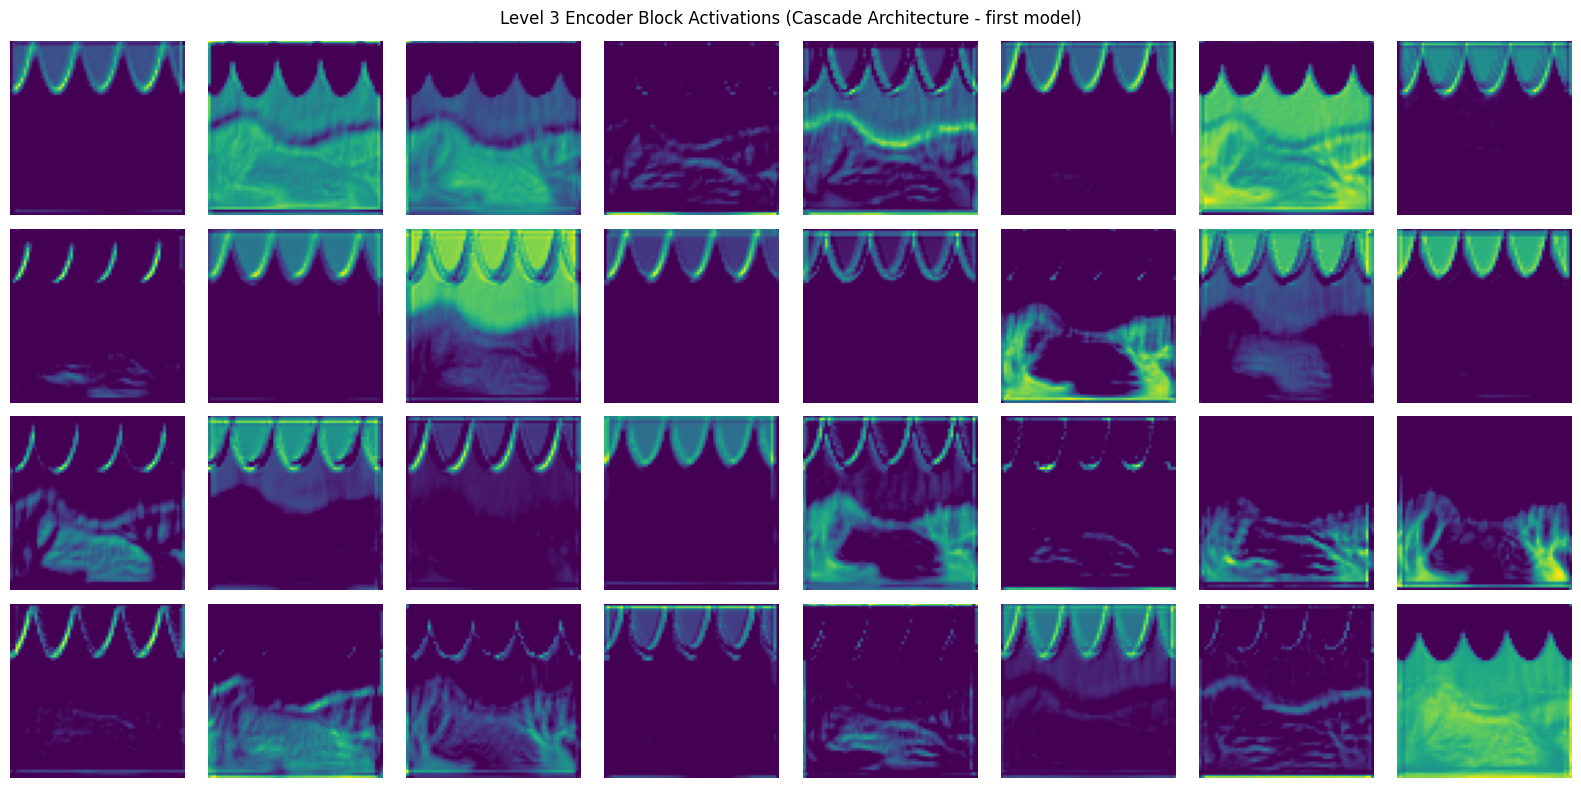

In [6]:
activation_maps.show(
    'Encoder block 3',
    4, 8,
    title='Level 3 Encoder Block Activations (Cascade Architecture - first model)'
)

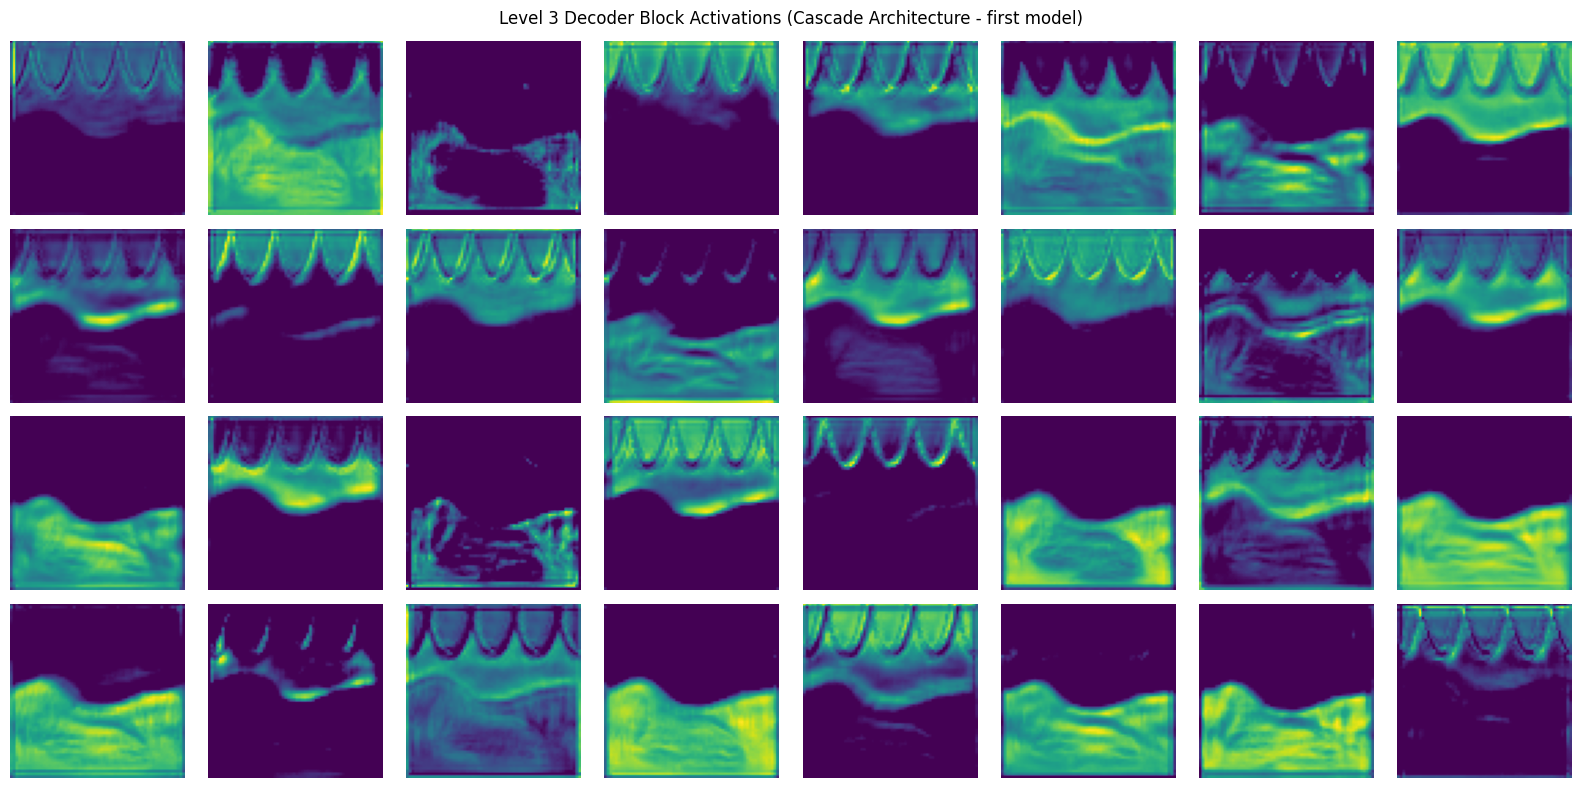

In [35]:
activation_maps.show(
    'Decoder block 3',
    4, 8,
    title='Level 3 Decoder Block Activations (Cascade Architecture - first model)'
)

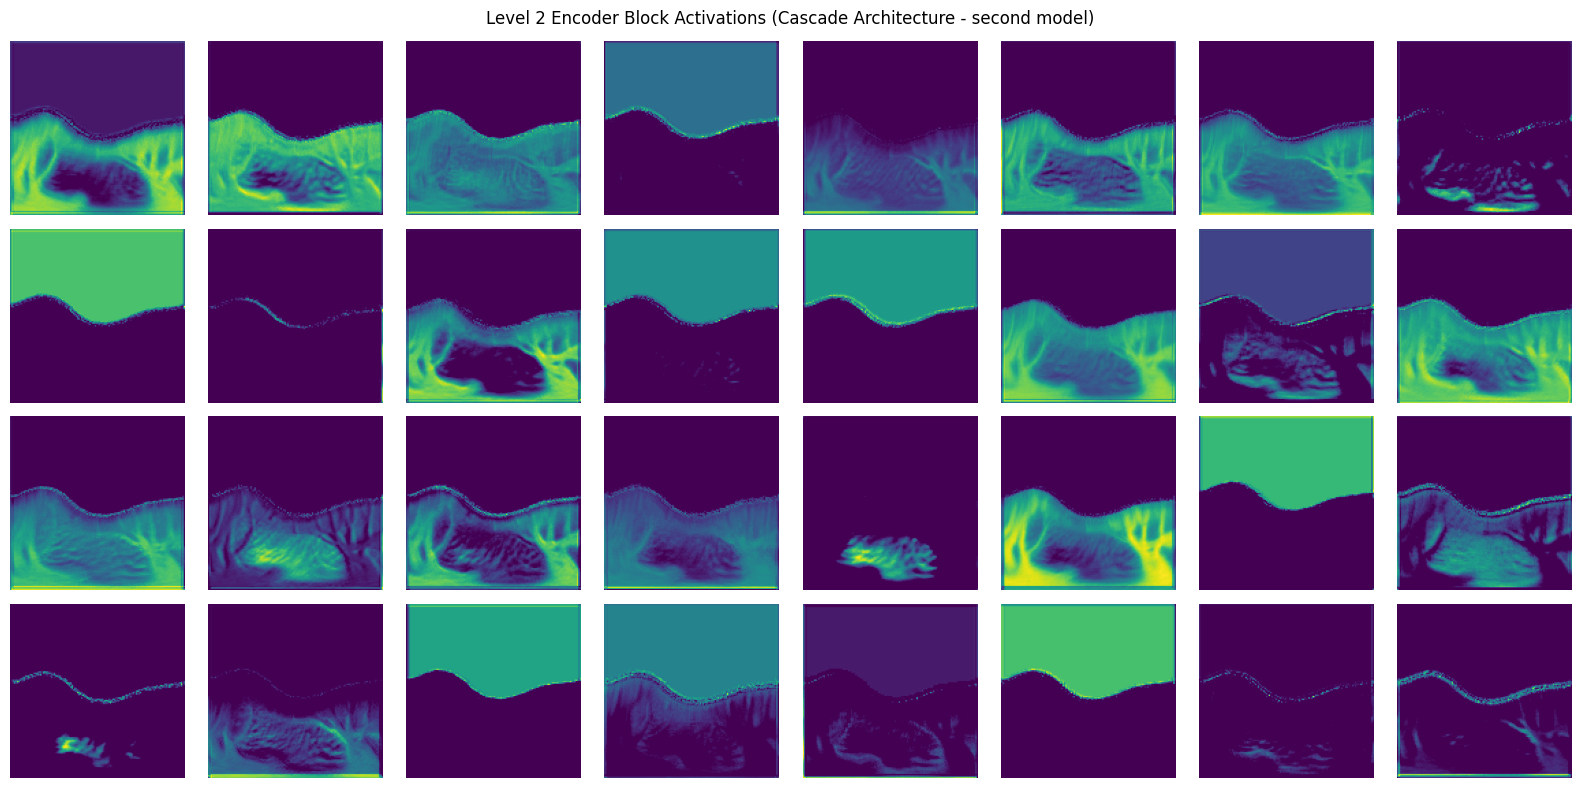

In [18]:
activation_maps.show(
    'Encoder block 2',
    4, 8,
    title='Level 2 Encoder Block Activations (Cascade Architecture - second model)'
)

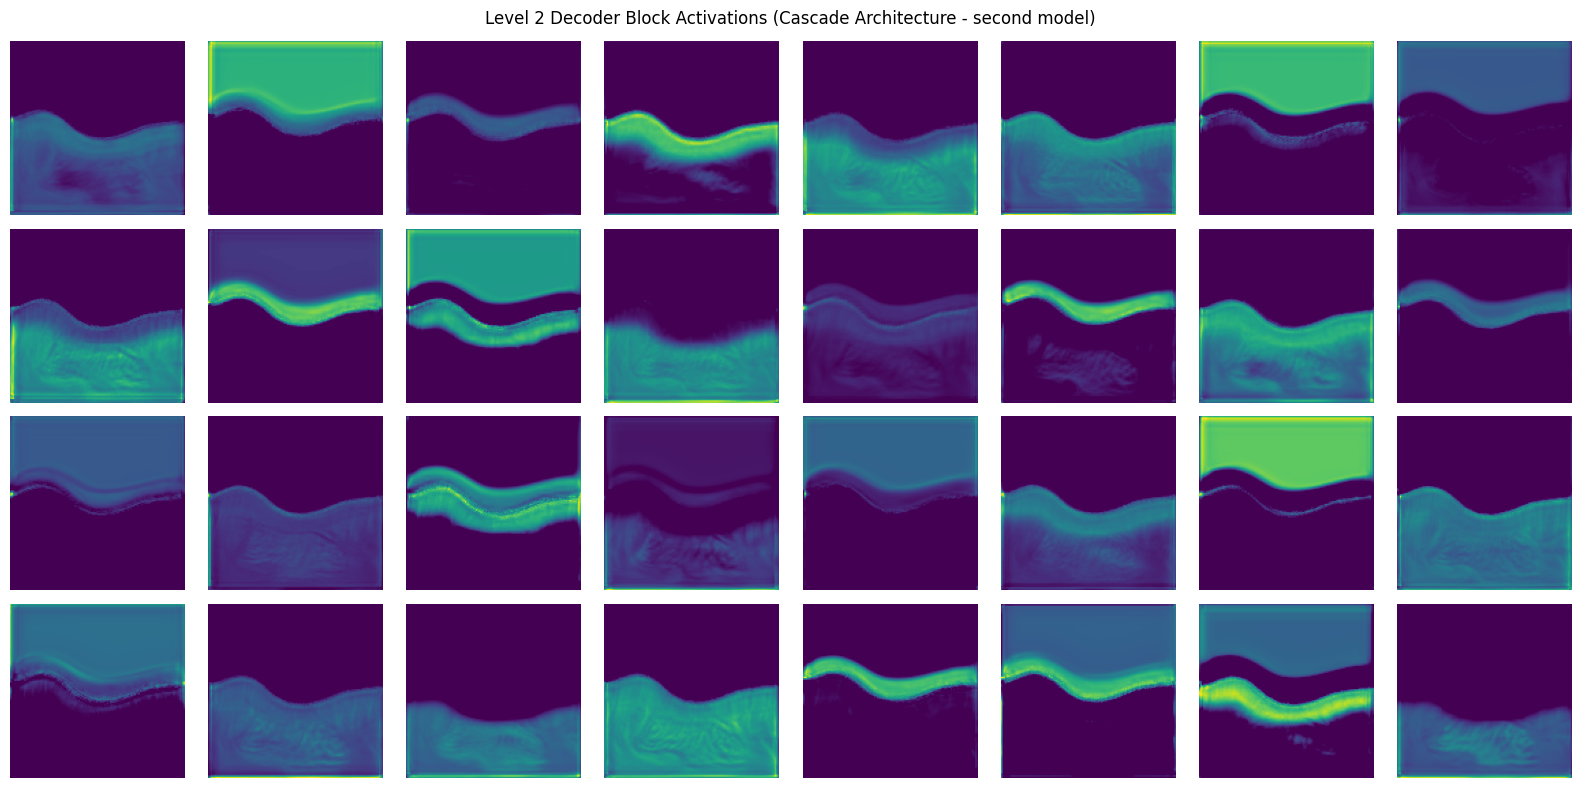

In [21]:
activation_maps.show(
    'Decoder block 2',
    4, 8,
    title='Level 2 Decoder Block Activations (Cascade Architecture - second model)'
)

### Dual activations

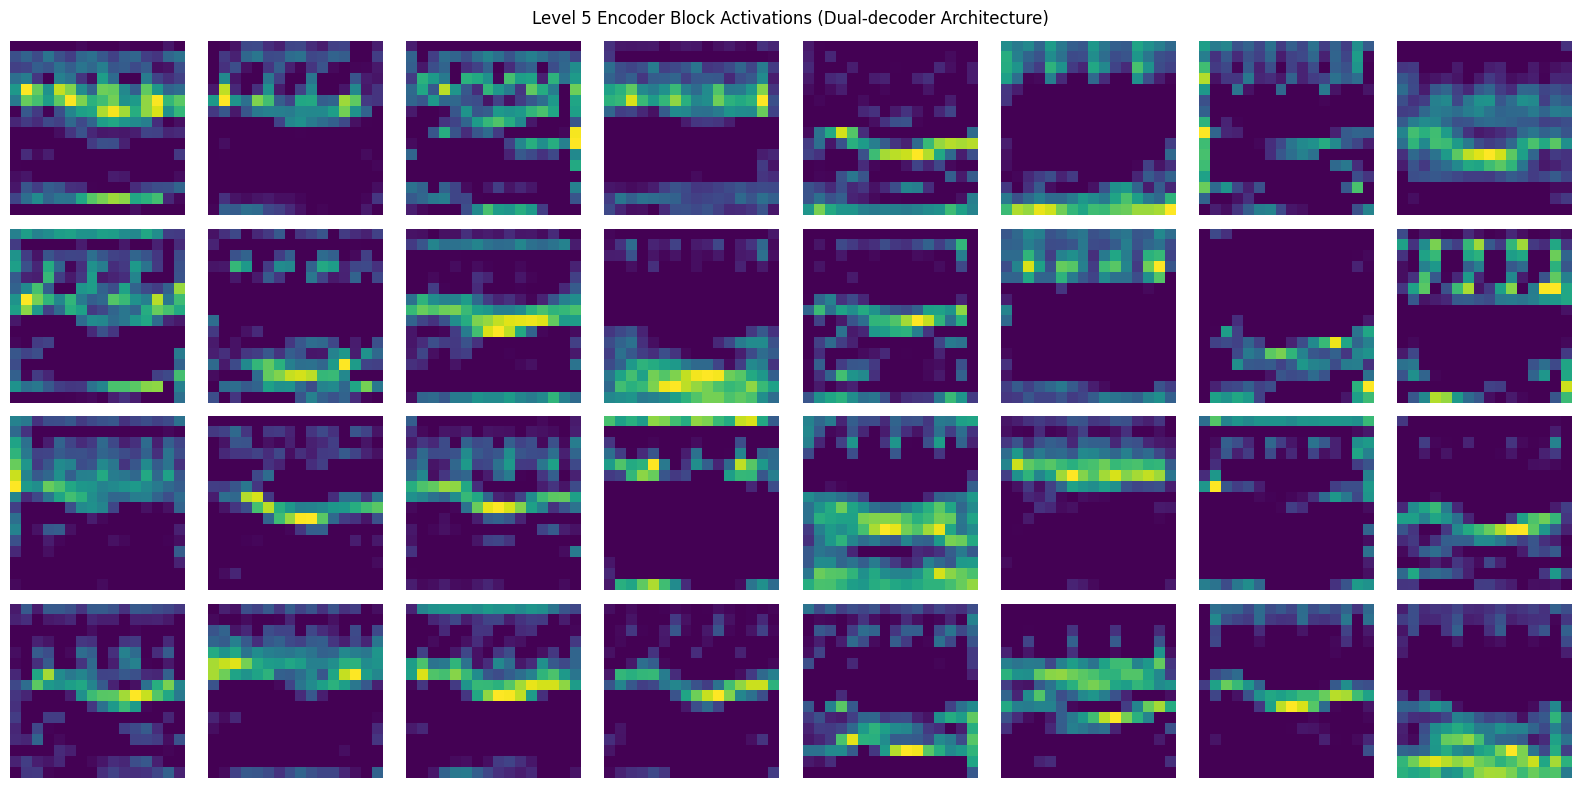

In [25]:
activation_maps.show(
    'Encoder block 5',
    4, 8,
    title='Level 5 Encoder Block Activations (Dual-decoder Architecture)'
)

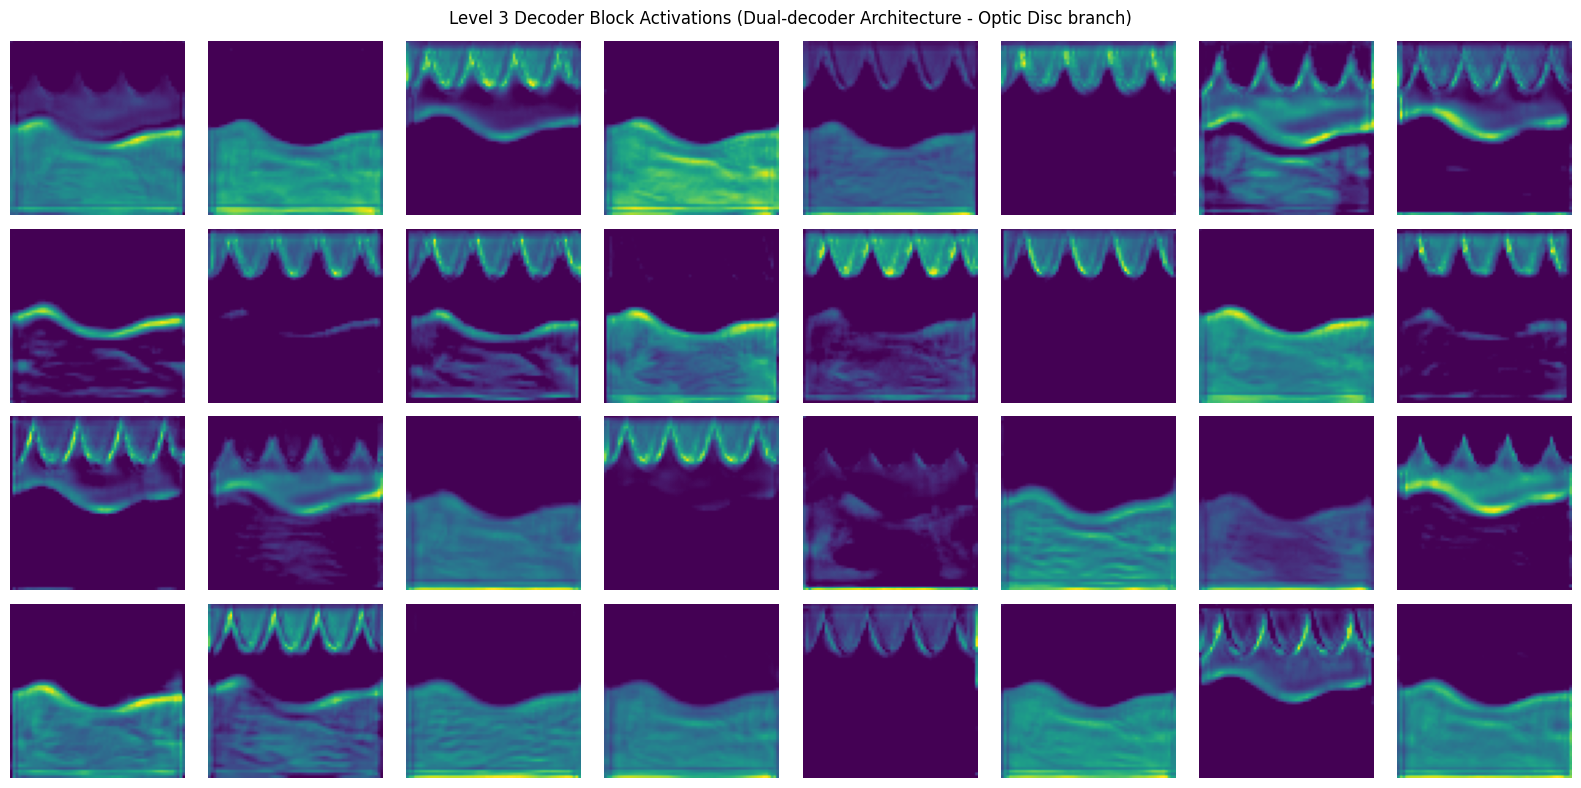

In [31]:
activation_maps.show(
    'OD Decoder block 3',
    4, 8,
    title='Level 3 Decoder Block Activations (Dual-decoder Architecture - Optic Disc branch)'
)

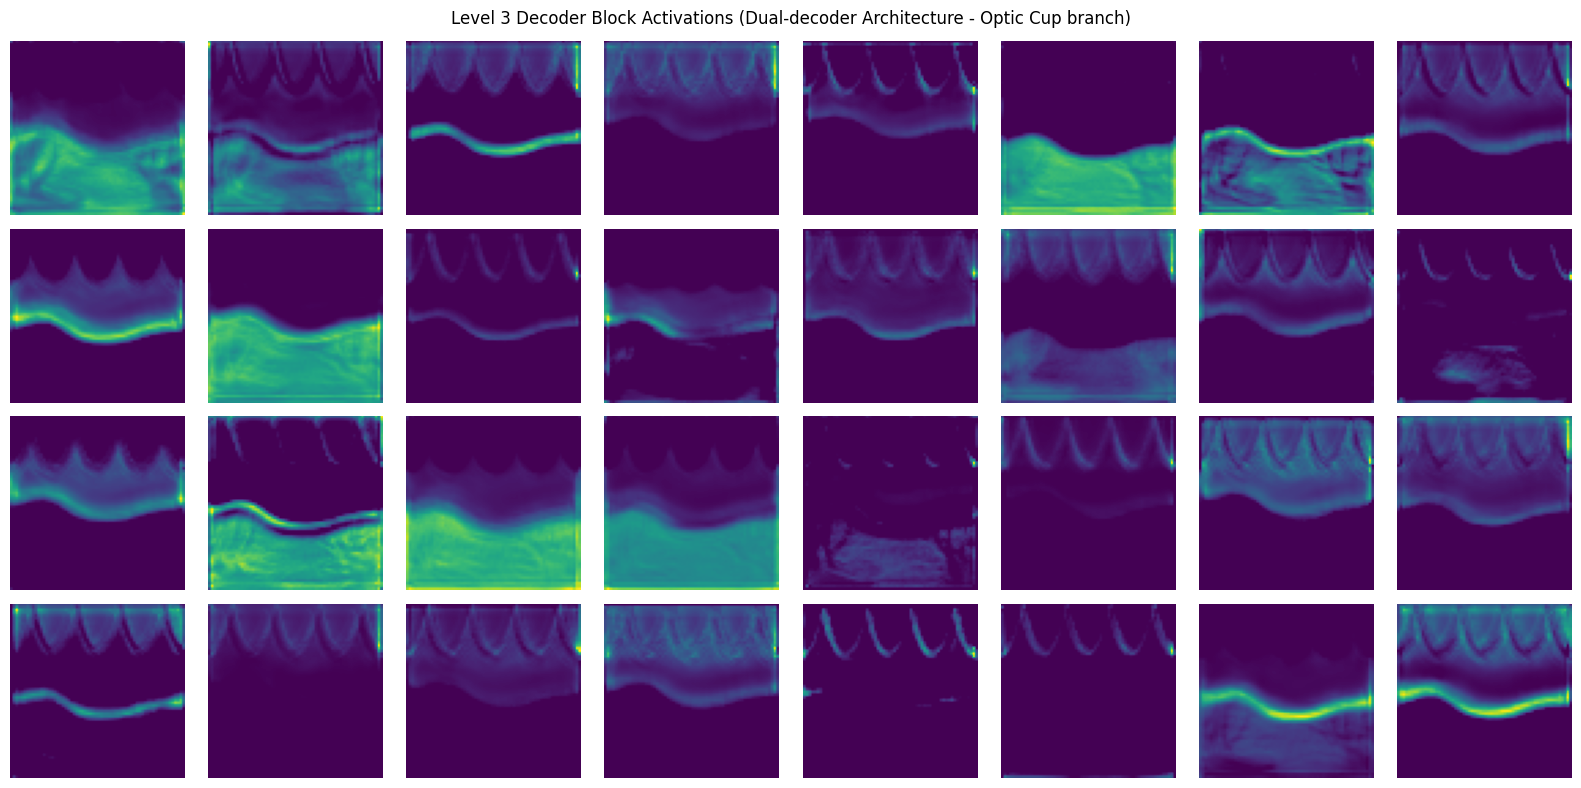

In [30]:
activation_maps.show(
    'OC Decoder block 3',
    4, 8,
    title='Level 3 Decoder Block Activations (Dual-decoder Architecture - Optic Cup branch)'
)

## Grad-CAM (Gradient-weighted Class Activation Mapping)

In [51]:
path = rf"..\models\{COORDS}\{MODEL}\dual.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model'].eval()

model_layers = dict(model.named_modules())
print(list(filter(lambda x: 'conv' in x, model_layers)))

=> Loading checkpoint: ..\models\polar\ref\dual.pth
['encoder.side1.conv', 'encoder.side2.conv', 'encoder.side3.conv', 'encoder.en1.conv1', 'encoder.en1.conv2', 'encoder.en2.conv1', 'encoder.en2.conv2', 'encoder.en3.conv1', 'encoder.en3.conv2', 'encoder.en4.conv1', 'encoder.en4.conv2', 'encoder.en5.conv1', 'encoder.en5.conv2', 'decoder1.de4_en2.conv', 'decoder1.de4_en4.conv', 'decoder1.de4_de5.conv', 'decoder1.de4.conv', 'decoder1.de4.cbam.sa.conv1', 'decoder1.de3_en1.conv', 'decoder1.de3_en3.conv', 'decoder1.de3_de4.conv', 'decoder1.de3.conv', 'decoder1.de3.cbam.sa.conv1', 'decoder1.de2_en2.conv', 'decoder1.de2_de3.conv', 'decoder1.de2.conv', 'decoder1.de2.cbam.sa.conv1', 'decoder1.de1_en1.conv', 'decoder1.de1_de2.conv', 'decoder1.de1_de3.conv', 'decoder1.de1_de4.conv', 'decoder1.de1.conv', 'decoder1.de1.cbam.sa.conv1', 'decoder2.de4_en2.conv', 'decoder2.de4_en4.conv', 'decoder2.de4_de5.conv', 'decoder2.de4.conv', 'decoder2.de4.cbam.sa.conv1', 'decoder2.de3_en1.conv', 'decoder2.de3_en

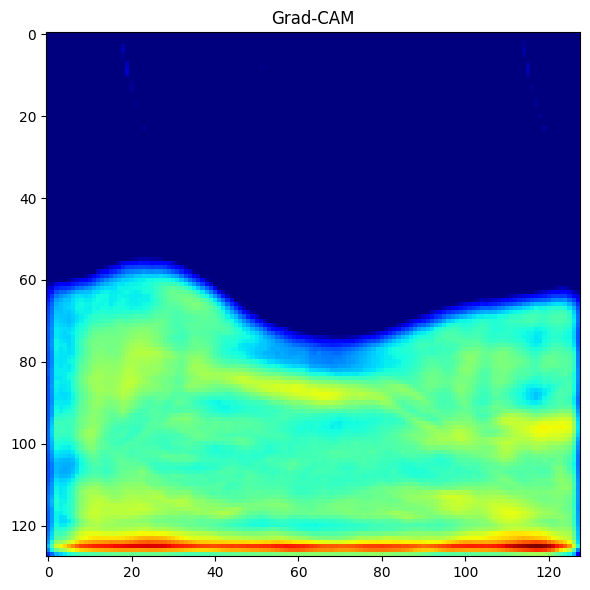

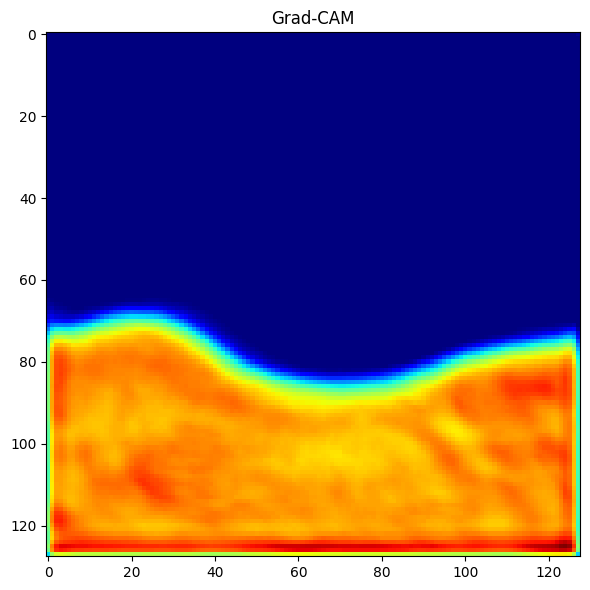

In [52]:
gradcam = GradCAM(model, model_layers['decoder1.de2.conv'])
dual_od_out = gradcam(images, output_index=0)
gradcam.show()
gradcam.unregister_hooks()

gradcam = GradCAM(model, model_layers['decoder2.de2.conv'])
dual_oc_out = gradcam(images, output_index=1)
gradcam.show()
gradcam.unregister_hooks()

In [45]:
path = rf"..\models\{COORDS}\{MODEL}\binary.pth"
checkpoint = load_checkpoint(path, map_location=device)
base_model = checkpoint['model'].eval()

path = rf"..\models\{COORDS}\{MODEL}\cascade.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model'].eval()

model_layers = dict(model.named_modules())
print(list(filter(lambda x: 'conv' in x, model_layers)))

with torch.no_grad():
    od_logits = base_model(images)
    od_probs = torch.sigmoid(od_logits)
    od_preds = (od_probs > 0.3).long()
od_masks = interprocess(od_preds)
cropped_images = images * od_masks

=> Loading checkpoint: ..\models\polar\ref\binary.pth
=> Loading checkpoint: ..\models\polar\ref\cascade.pth
['encoder.side1.conv', 'encoder.side2.conv', 'encoder.side3.conv', 'encoder.en1.conv1', 'encoder.en1.conv2', 'encoder.en2.conv1', 'encoder.en2.conv2', 'encoder.en3.conv1', 'encoder.en3.conv2', 'encoder.en4.conv1', 'encoder.en4.conv2', 'encoder.en5.conv1', 'encoder.en5.conv2', 'decoder.de4_en2.conv', 'decoder.de4_en4.conv', 'decoder.de4_de5.conv', 'decoder.de4.conv', 'decoder.de4.cbam.sa.conv1', 'decoder.de3_en1.conv', 'decoder.de3_en3.conv', 'decoder.de3_de4.conv', 'decoder.de3.conv', 'decoder.de3.cbam.sa.conv1', 'decoder.de2_en2.conv', 'decoder.de2_de3.conv', 'decoder.de2.conv', 'decoder.de2.cbam.sa.conv1', 'decoder.de1_en1.conv', 'decoder.de1_de2.conv', 'decoder.de1_de3.conv', 'decoder.de1_de4.conv', 'decoder.de1.conv', 'decoder.de1.cbam.sa.conv1']


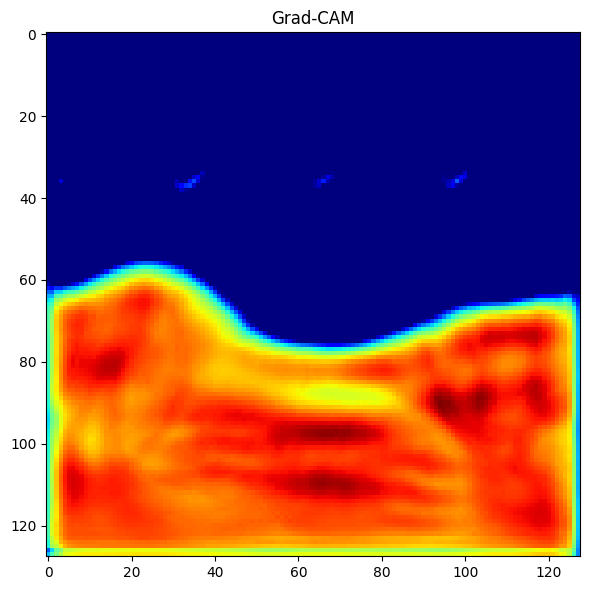

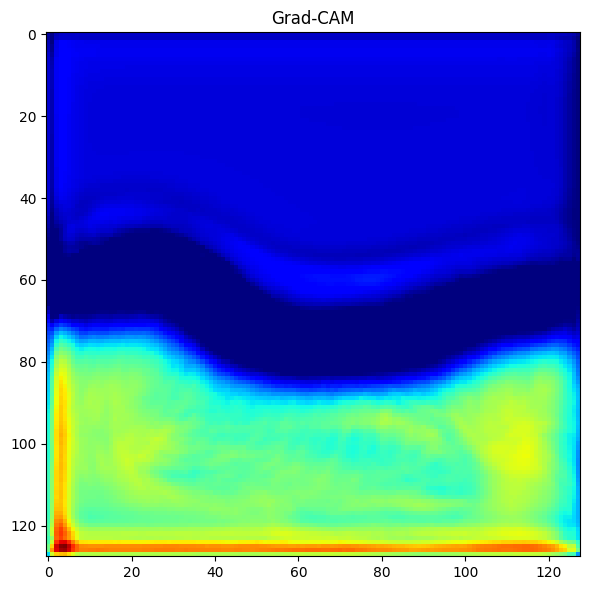

In [47]:
gradcam = GradCAM(base_model, dict(base_model.named_modules())['decoder.de2.conv'])
cascade_od_out = gradcam(images)
gradcam.show()
gradcam.unregister_hooks()

gradcam = GradCAM(model, model_layers['decoder.de2.conv'])
cascade_oc_out = gradcam(cropped_images)
gradcam.show()
gradcam.unregister_hooks()

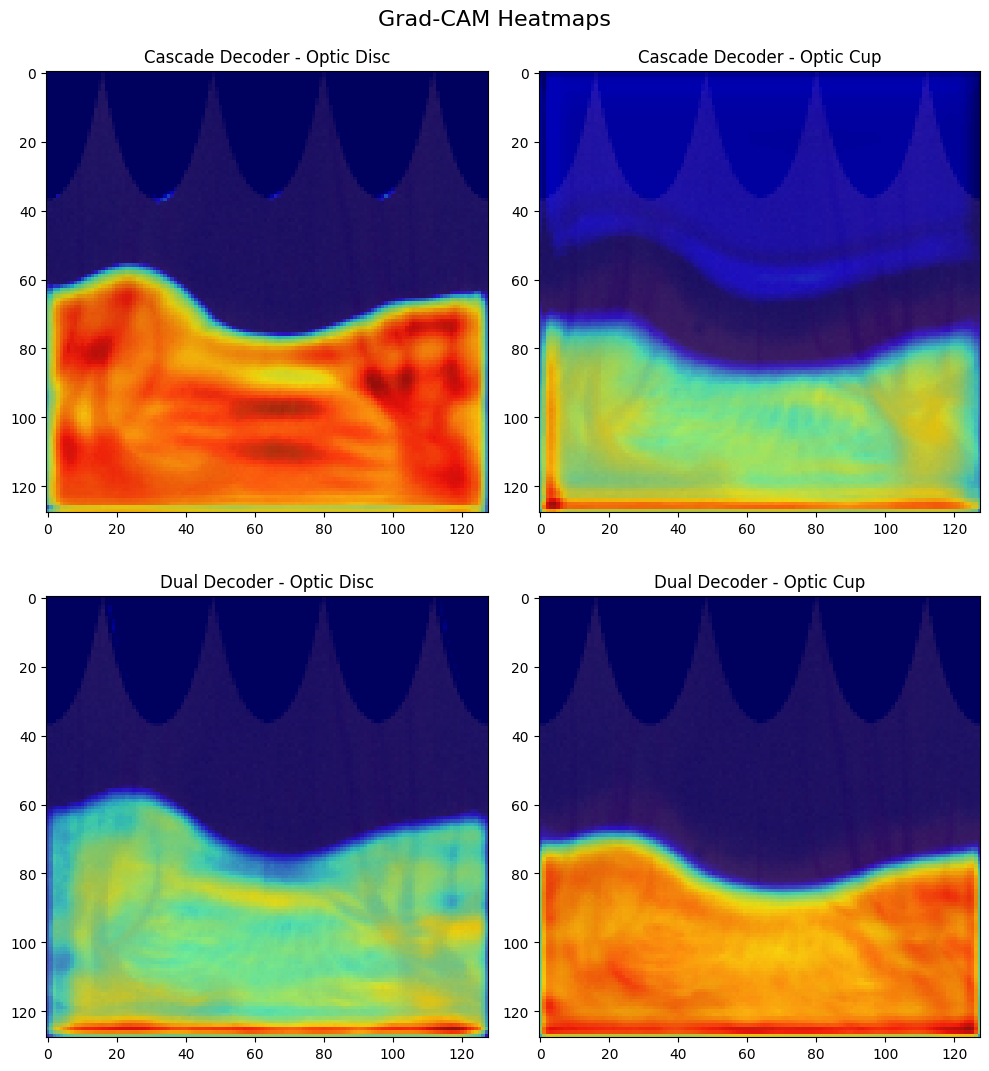

In [69]:
img = images[0].permute(1, 2, 0).numpy()
img = cv.resize(img, (dual_od_out[0].shape[1], dual_od_out[0].shape[0]))
img -= img.min()
img /= img.max()

fig, ax = plt.subplots(2, 2, figsize=(10, 11))
ax = ax.flatten()

alpha = 0.7

ax[0].imshow(img)
ax[0].imshow(cascade_od_out[0], cmap='jet', alpha=alpha)
ax[0].set_title('Cascade Decoder - Optic Disc')
ax[1].imshow(img)
ax[1].imshow(cascade_oc_out[0], cmap='jet', alpha=alpha)
ax[1].set_title('Cascade Decoder - Optic Cup')

ax[2].imshow(img)
ax[2].imshow(dual_od_out[0], cmap='jet', alpha=alpha)
ax[2].set_title('Dual Decoder - Optic Disc')
ax[3].imshow(img)
ax[3].imshow(dual_oc_out[0], cmap='jet', alpha=alpha)
ax[3].set_title('Dual Decoder - Optic Cup')

fig.suptitle('Grad-CAM Heatmaps', fontsize=16)
plt.tight_layout()
plt.show()